# Challenge: What is the future selling price of a home?

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important.

In this competition, students are required to develop a full-fledged approach to make predictions about the future sale prices of homes. A full-fledged approach constist, at least, in the following steps:

* Descriptive statistics about the data
* Data cleaning and pre-processing
* Defining a modeling approach to the problem
* Build such a statistical model
* Validate the outcome of the model

Now, should you ask a home buyer to describe their dream house, they probably wouldn't begin with describing features such as the height of the basement ceiling or the proximity to a railroad. As you will see, the dataset we use in this competition proves that many more features influence price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in a small city in the US, this competition challenges you to predict the final price of each home.

## Imports and usefull functions

In [38]:
import os
import sys
import re
import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import pickle
import math
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, MultiTaskLasso,LassoCV
from sklearn.model_selection import cross_val_score,GridSearchCV
#from bayes_opt import BayesianOptimization
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import seaborn as sns
sns.set(color_codes=True)
base = "challenge_data/"

In [39]:
# This functions plots the correlation of the numerical value of a dataframe
def plotCorrelation(dataframe):
    corr = dataframe.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 5, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
    print('Correlation plot')

## Loading the data

We have two files containg the data :
* train.csv - the training dataset
* test.csv - the test dataset

In [40]:
df_train = pd.read_csv(base + 'train.csv')
df_test  = pd.read_csv(base + 'test.csv')
df = pd.concat([df_train.drop(columns=['SalePrice']), df_test])

First thing first lets see what the data looks like.

In [41]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The test data is exactly the same but without the target column (SalePrice) and less rows.

In [42]:
print("Train data shape : ", df_train.shape)
print("Test data shape  : ", df_test.shape)

Train data shape :  (1200, 81)
Test data shape  :  (260, 80)


## Descriptive statistics about the data

In this section we will make a first visualization of the data. This will provide us a first view of the dataset.

### SalePrice

Since this is the target attribute we will consider it first.

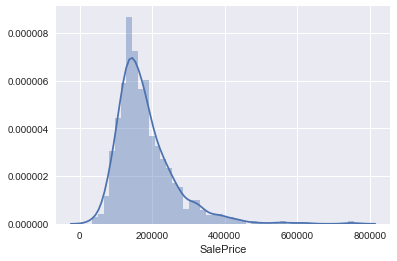

In [43]:
sns.distplot(df_train['SalePrice']);

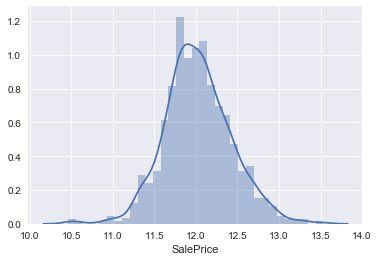

In [44]:
sns.distplot(np.log(df_train['SalePrice']));

We have a few houses with a sale price above 500 000$. The log of SalePrice seems to follow a normal distributon. A normal distribution will give better result to our models, therefore we will work only with the log(SalePrice) for now on.

In [45]:
df_train.SalePrice = np.log(df_train.SalePrice)

Since there are a lot of attributes to consider (there are 79) we have two options :
1. Follow the order of the columns
2. Follow the order of correlation (most correlated to less correlated).

We opted for the second option. However we can't compute the correlation betweeen number and categorical value (strings). Therefore we will first consider the 10 most correlated and treat the categorical features with the rest of the nulerical value 

Correlation plot


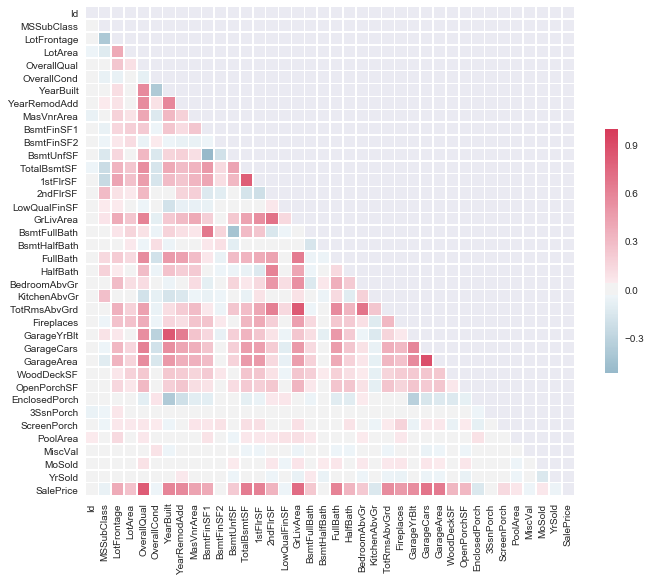

In [46]:
plotCorrelation(df_train)

In [47]:
df_train.corr().SalePrice.sort_values(ascending=False)[1:11]

OverallQual     0.818680
GrLivArea       0.728163
GarageCars      0.681809
GarageArea      0.651121
TotalBsmtSF     0.641615
1stFlrSF        0.610721
FullBath        0.607066
YearBuilt       0.590738
YearRemodAdd    0.573284
TotRmsAbvGrd    0.554775
Name: SalePrice, dtype: float64

### OverallQual

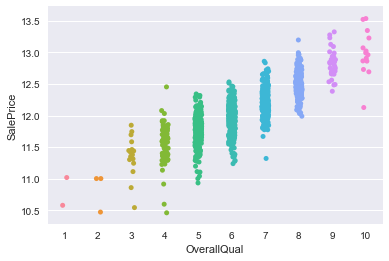

In [48]:
sns.stripplot(x="OverallQual", y="SalePrice", data=df_train, jitter=True);

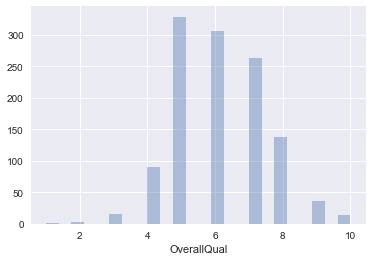

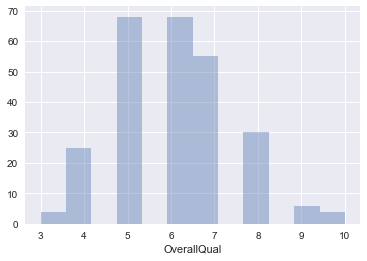

In [61]:
plt.figure()
sns.distplot(df_train.OverallQual, kde=False);
plt.figure()
sns.distplot(df_test.OverallQual, kde=False);